# Big data lab

## import library

In [1]:
import pandas as pd
import pickle
import my_func
import lightgbm as lgb
import warnings
warnings.filterwarnings('ignore')
import numpy as np
from sklearn.model_selection import KFold 
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_auc_score, accuracy_score, precision_score, recall_score, f1_score
from datetime import datetime, timedelta
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
import seaborn as sns
import matplotlib.pyplot as plt
import time

sns.set()

fe_name_tr = 'churn_train_model_fe.pickle'
b_num_name_tr ='churn_train_model_b_num.pickle'
dpi_name_tr ='churn_train_model_dpi.pickle'

fe_name_te = 'churn_test_model_fe.pickle'
b_num_name_te ='churn_test_model_b_num.pickle'
dpi_name_te ='churn_test_model_dpi.pickle'

file_path = r'D:\BDL-Final\data-from-BDL' + '\\'

# settings for dataframe
pd.set_option('display.max_columns', None)

In [2]:
params = {
    'boosting_type': 'gbdt',
    'objective': 'binary',
    'metric': 'auc',
    'learning_rate': 0.1,
    'num_leaves': 31,
    'max_depth': -1,
    'min_child_samples': 20,
    'subsample': 1.0,
    'colsample_bytree': 1.0,
    'reg_alpha': 0.0,
    'reg_lambda': 0.0,
    'n_estimators': 100,
    'early_stopping_rounds': 20,
    'is_unbalance': True,
    'random_state': 42
}


In [2]:
# Load dataframes
df_train_fe = pd.read_pickle(file_path+fe_name_tr)
df_train_dpi = pd.read_pickle(file_path+dpi_name_tr)
df_train_b_num = pd.read_pickle(file_path+b_num_name_tr)

df_test_fe = pd.read_pickle(file_path+fe_name_te)
df_test_dpi = pd.read_pickle(file_path+dpi_name_te)
df_test_b_num = pd.read_pickle(file_path+b_num_name_te)



In [13]:
import lightgbm as lgb
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
import numpy as np


# Prepare your data (X and y)
X = df_train_fe.drop(['target', 'abon_id'], axis=1)
y = df_train_fe['target']

# Split the data into train and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=777)

# Define the LGBMClassifier model
clf = lgb.LGBMClassifier(is_unbalance=True)

# Define the number of folds for cross-validation
n_splits = 5

# Initialize an empty list to store the test AUC scores for each fold
test_scores = []

# Perform K-fold cross-validation
kf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=777)
for train_index, test_index in kf.split(X_train, y_train):
    X_train_fold, X_test_fold = X_train.iloc[train_index], X_train.iloc[test_index]
    y_train_fold, y_test_fold = y_train.iloc[train_index], y_train.iloc[test_index]
    
    # Train the model on the current fold
    clf.fit(X_train_fold, y_train_fold)
    
    # Make predictions on the validation set of the current fold
    y_val_pred = clf.predict(X_test_fold)
    
    # Calculate and store the AUC score for the current fold
    test_scores.append(roc_auc_score(y_test_fold, y_val_pred))

# Print the test AUC scores for each fold
for i, score in enumerate(test_scores):
    print(f"Fold {i+1} Test AUC = {score:.3f}")

# Calculate and print the average test AUC across all folds
print(f"Average Test AUC = {np.mean(test_scores):.3f}")


Fold 1 Test AUC = 0.826
Fold 2 Test AUC = 0.821
Fold 3 Test AUC = 0.818
Fold 4 Test AUC = 0.826
Fold 5 Test AUC = 0.815
Average Test AUC = 0.821


In [5]:
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

def plot_roc_auc(y_train, y_train_pred, y_test, y_test_pred, title):
    fpr_train, tpr_train, _ = roc_curve(y_train, y_train_pred)
    auc_train = roc_auc_score(y_train, y_train_pred)

    fpr_test, tpr_test, _ = roc_curve(y_test, y_test_pred)
    auc_test = roc_auc_score(y_test, y_test_pred)

    plt.plot(fpr_train, tpr_train, color='blue', label="Train, AUC={:.3f}".format(auc_train), linestyle='-')
    plt.plot(fpr_test, tpr_test, color='black', label="Test, AUC={:.3f}".format(auc_test), linestyle='--')

    plt.plot([0, 1], [0, 1], color='gray', linestyle='--')

    plt.xticks(np.arange(0.0, 1.1, step=0.1))
    plt.xlabel("False Positive Rate", fontsize=15)

    plt.yticks(np.arange(0.0, 1.1, step=0.1))
    plt.ylabel("True Positive Rate", fontsize=15)

    plt.title(title, fontweight='bold', fontsize=15)
    plt.legend(prop={'size': 13}, loc='lower right')

    plt.show()


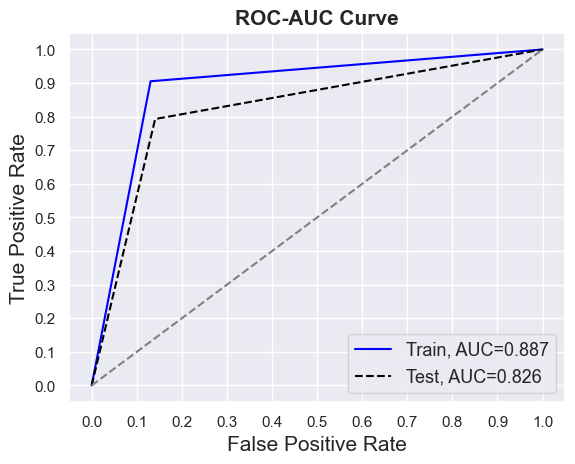

In [10]:
plot_roc_auc(y_train, y_train_pred, y_test, y_test_pred, "ROC-AUC Curve")


In [12]:
#saving model
my_func.save_model(clf, X.columns.tolist()) 


Save LGBMClassifier_24062023_15_30.pickle


## Prediction using Test dataset

Test AUC = 0.898


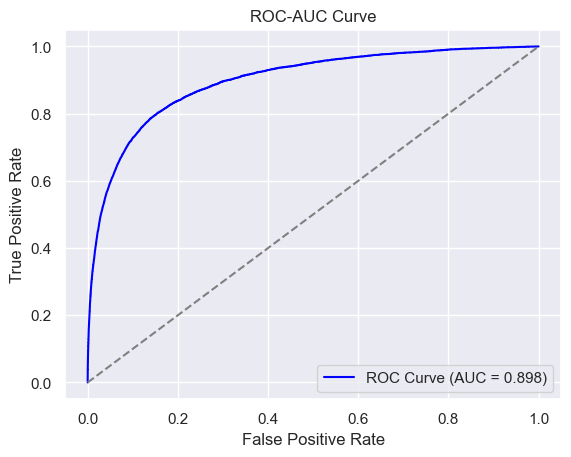

In [23]:

import lightgbm as lgb
import pickle
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt


# Define the file name of the pickle file
pickle_file = "LGBMClassifier_24062023_15_30.pickle"

# Load the model
model, features = my_func.load_pickle(pickle_file)

# Prepare the test data (X_test)
y_test = df_test_fe['target']
X_test = df_test_fe.drop(['target', 'abon_id'], axis=1)


# Make predictions on the test data
y_pred = model.predict(X_test)

# Calculate the probabilities of the positive class
y_pred_proba = model.predict_proba(X_test)[:, 1]

# Calculate the ROC-AUC score
auc = roc_auc_score(y_test, y_pred_proba)
print(f"Test AUC = {auc:.3f}")

# Plot the ROC-AUC curve
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
plt.plot(fpr, tpr, color='blue', label="ROC Curve (AUC = {:.3f})".format(auc))
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC-AUC Curve")
plt.legend()
plt.show()


## Feature Importance

In [ ]:
# import lightgbm as lgb
# import pandas as pd

# # Train the model
# model.fit(X_train, y_train)

# Get feature importances
importances = model.feature_importances_
feature_names = X.columns

# Create a DataFrame with feature names and importances
df_importances = pd.DataFrame({'Feature': feature_names, 'Importance': importances})

# Sort the DataFrame by importance in descending order
df_importances = df_importances.sort_values(by='Importance', ascending=False)

# Print the DataFrame
print(df_importances)



In [35]:
#save feature importance in file to compare later
df_importances.to_excel('feature_import_24062023_15_30.xlsx')

## First look

# Feature Engineering


In [ ]:
# перевірка на missing значення
ms_val = my_func.count_missing_values(df_train_fe)
ms_val

## Working with missing values

In [29]:
#filtered_df = df_train_dpi[df_train_dpi['Application'] == 14]



In [28]:
filtered_df.to_excel('14.xlsx')

735

In [3]:
# Transform DPI dataset


# Unique values of 'Application'
unique_abon_ids = df_train_dpi['abon_id'].unique()
unique_values_train = df_train_dpi['Application'].unique()
unique_values_test = df_test_dpi['Application'].unique()
#unique_applications = np.unique(np.concatenate((unique_values_train, unique_values_test)))
unique_applications = np.array([14, 23])

# Create the df_t dataframe with 'abon_id' column
df_t = pd.DataFrame({'abon_id': unique_abon_ids})

# Pre-filter df_train_dpi for each application
filtered_dfs = {}
for app in unique_applications:
    filtered_dfs[app] = df_train_dpi[df_train_dpi['Application'] == app]

# Initialize dictionaries to store column values
column_values = {}
for app in unique_applications:
    col_names = [f"{app}_SUM_of_Duration_sec", f"{app}_SUM_of_Volume_kb", f"{app}_SUM_of_Count_events", f"{app}_MAX_of_day_cnt"]
    column_values[col_names[0]] = []
    column_values[col_names[1]] = []
    column_values[col_names[2]] = []
    column_values[col_names[3]] = []

# Progress update interval in seconds
progress_interval = 3 * 60  # 3 minutes

# Iterate over each row in df_t
total_rows = len(df_t)
start_time = time.time()
last_progress_time = start_time
for row_index, row in df_t.iterrows():
    abon_id = row['abon_id']
    
    # Iterate over each application
    for app_index, app in enumerate(unique_applications):
        col_names = [f"{app}_SUM_of_Duration_sec", f"{app}_SUM_of_Volume_kb", f"{app}_SUM_of_Count_events", f"{app}_MAX_of_day_cnt"]
        filtered_df = filtered_dfs[app]
        
        # Find the values for the current abon_id and application
        values = filtered_df.loc[filtered_df['abon_id'] == abon_id, ['SUM_of_Duration_sec', 'SUM_of_Volume_kb', 'SUM_of_Count_events', 'MAX_of_day_cnt']].values
        
        if len(values) > 0:
            column_values[col_names[0]].append(values[0][0])
            column_values[col_names[1]].append(values[0][1])
            column_values[col_names[2]].append(values[0][2])
            column_values[col_names[3]].append(values[0][3])
        else:
            column_values[col_names[0]].append(None)
            column_values[col_names[1]].append(None)
            column_values[col_names[2]].append(None)
            column_values[col_names[3]].append(None)
    
    # Print progress every 3 minutes
    current_time = time.time()
    elapsed_time = current_time - last_progress_time
    if elapsed_time >= progress_interval:
        progress = (row_index + 1) / total_rows * 100
        print(f"Progress: {progress:.2f}%")
        last_progress_time = current_time

# Add the values as new columns to df_t
for col_name, values in column_values.items():
    df_t[col_name] = values

# Print the resulting df_t dataframe
#print(df_t)


In [4]:
df_t.to_excel('df_t2.xlsx')


In [6]:
df_tr = ds_base_prep(df_train_fe)

In [7]:
y = df_tr['target']
X = df_tr.drop(['target', 'abon_id'], axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=777, shuffle=True)


## Train Model

### Base Model

## Predict on Test sample


In [48]:
y_test = df_test_fe['target']
X_test = df_test_fe.drop(['target', 'abon_id'], axis=1)
X_test.replace(np.inf, -1, inplace=True)
X_test.fillna(-1, inplace=True)

In [ ]:
pred_lgb = lgb_model.predict(X_train)
pred_lgb_test = lgb_model.predict_proba(X_test)[:,1]

In [ ]:
#binary_classification_metrics(y, clf.predict(X), y_test, clf.predict(X_test))

In [74]:
def plot_roc_auc(y_train, y_train_pred, y_test, y_test_pred, title):
    # Calculate the ROC curve and AUC for train set
    fpr_train, tpr_train, _ = roc_curve(y_train, y_train_pred)
    auc_train = roc_auc_score(y_train, y_train_pred)

    # Calculate the ROC curve and AUC for test set
    fpr_test, tpr_test, _ = roc_curve(y_test, y_test_pred)
    auc_test = roc_auc_score(y_test, y_test_pred)

    # Plot the ROC curve for train set
    plt.plot(fpr_train, tpr_train, color='blue',
             label="Навчальна вибірка, AUC={:.3f}".format(auc_train), linestyle='-')

    # Plot the ROC curve for test set
    plt.plot(fpr_test, tpr_test, color='black',
             label="Тестова вибірка, AUC={:.3f}".format(auc_test), linestyle='--')

    # Plot the diagonal line for reference
    plt.plot([0, 1], [0, 1], color='gray', linestyle='--')

    # Set x-axis and y-axis labels
    plt.xlabel("False Positive Rate", fontsize=15)
    plt.ylabel("True Positive Rate", fontsize=15)

    # Set x-axis and y-axis tick marks
    plt.xticks(np.arange(0.0, 1.1, step=0.1))
    plt.yticks(np.arange(0.0, 1.1, step=0.1))

    # Set the title and legend
    plt.title(title, fontweight='bold', fontsize=15)
    plt.legend(prop={'size': 13}, loc='lower right')

    # Show the plot
    plt.show()
